<a href="https://colab.research.google.com/github/gawronn91/Fraud_detection/blob/main/FS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

## 1.1 Explaining concept of feature selection

The purpose of Feature Selection is to reduce the number of input variables for the predictive model. <br>
There are 2 big advantages of reducing the number of columns:
* Reduction of computational cost of modeling
* Improve the performance of the model

The first point is rather clear - with a smaller amount of columns, the dataset itself is also smaller, so fewer calculations need to be performed.<br>
Improvement of the performance of the model works in the same way as Cross-Validation. <br>
The improvement won't be visible on the training model, because adding a new feature cannot decrease the accuracy of predictions on the training dataset. <br>
In the worst scenario accuracy will stay at the same level, but it rather increases model accuracy.

Then why reduce variables, if their higher number equals higher accuracy?<br>
Unfortunately, a big number of variables leads to problems similar to model overfitting.<br>

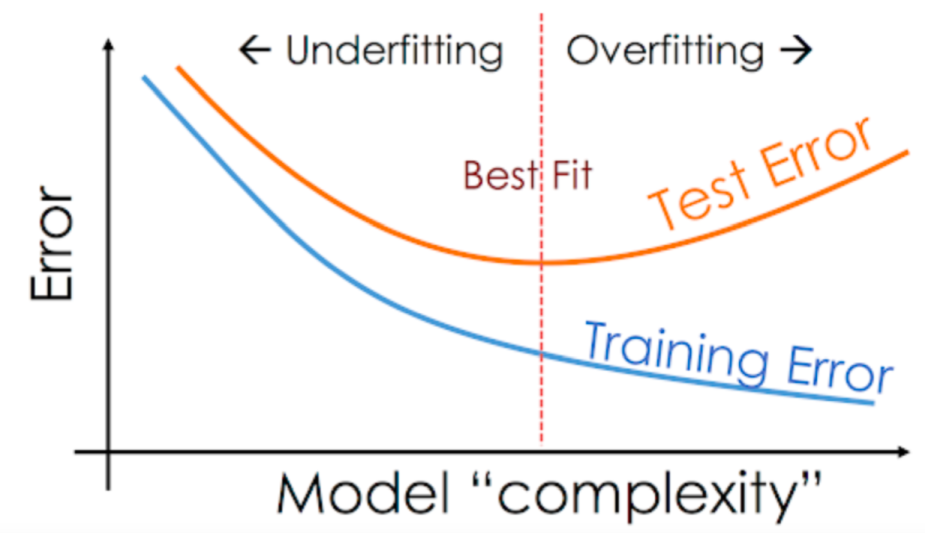

Overfitting is a problem, which deals with model complexity.<br>
The more complex model is, the more it sees local data patterns, which are rather associated with variance and randomness than the actual true influence on the response.

The same mechanism exists with a number of features.<br>
The more features in the dataset, the more response is associated only with a subset of predictors, but there is no true influence on the response.<br>
This is why we limit the number of features, to keep only those that have a true influence on the target variable on a larger scale.

I will use 2 methods of feature selection:
* Boruta algotithm
* Permutation importance method

# 1.2 Importing Necessary Libraries

In [ ]:
# Data Analysis
import pandas as pd
import numpy as np

# System
import os, gc
from IPython.display import display

# Math
import math

#DateTime
from datetime import datetime
from datetime import timedelta

# Data Visualization
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec # to do the grid of plots
import seaborn as sns

# Machine Learning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, KFold, GroupKFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, precision_score, recall_score, fbeta_score, confusion_matrix, plot_confusion_matrix, precision_recall_curve, accuracy_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgb


#Feature selection
from boruta import BorutaPy
import eli5
from eli5.sklearn import PermutationImportance

# Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
sns.set_theme(style="white")

# 2. Data Loading and checking

## 2.1 Loading the data:

In [ ]:
train_df = pd.read_pickle('/Users/gawro/OneDrive/Pulpit/PJATK/Projekt_wlasny/2tygodnie_do_konca/train_nan(-999).pkl')

## 2.2 List of columns based on their type

In [ ]:
data_types = ['int8', 'int16', 'int32', 'float16', 'float32', 'category']
for dt in data_types:
    print('{} columns: '.format(dt), list(train_df.columns[train_df.dtypes == dt]), sep='\n', end='\n\n')

int8 columns: 
['isFraud']

int16 columns: 
['card1']

int32 columns: 
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'TransactionMinute', 'TransactionHour', 'TransactionDay', 'TransactionDT_old', 'TransactionAmtRange', 'P_emaildomain_no_suffix', 'R_emaildomain_no_suffix', 'OS', 'Browser', 'id1', 'id2', 'id3', 'id4', 'id5', 'bank_type']

float16 columns: 
['TransactionAmt', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D5', 'D9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31

## 2.3 Initial declaration of parameters

In [ ]:
# Columns to be removed
rm_cols = ['isFraud', 'TransactionDT', 'TransactionDT_old']

# Final features
features_columns = [col for col in list(train_df) if col not in rm_cols]

# Reseting index of train dataframe
train_df.reset_index(inplace=True)

# Declaring input and output 
X = train_df[features_columns]
y = train_df['isFraud']

# Additional parameters:
seed = 42
n_splits = 5

# 3. Boruta feature importance

## 3.1 Explaining the method

The Boruta algorithm is a wrapper built around the random forest classifier. It tries to evaluate the features and rank their importance. <br>
Boruta compares the feature importance (Z-score) with the feature importance of a shuffled copy of the original dataset (shadow features). <br>
When a feature has a higher Z-score than the maximum Z-score of its shadow features than the best of the shadow features, Boruta records a "hits" for that feature. Other features are put in the rejected bin.

Boruta is a method of eliminating features by only capturing the important, interesting columns that have a high degree of influence on the target variable.

## 3.2 Class which alows boruta to run on LGB model

In [ ]:
from sklearn.utils import check_random_state

class BorutaPyForLGB(BorutaPy):
    def __init__(self, estimator, n_estimators=1000, perc=100, alpha=0.05,
                 two_step=True, max_iter=100, random_state=None, verbose=0):
        super().__init__(estimator, n_estimators, perc, alpha,
                         two_step, max_iter, random_state, verbose)
        self._is_lightgbm = 'lightgbm' in str(type(self.estimator))
        
    def _fit(self, X, y):
        # check input params
        self._check_params(X, y)

        if not isinstance(X, np.ndarray):
            X = self._validate_pandas_input(X) 
        if not isinstance(y, np.ndarray):
            y = self._validate_pandas_input(y)

        self.random_state = check_random_state(self.random_state)
        # setup variables for Boruta
        n_sample, n_feat = X.shape
        _iter = 1
        # holds the decision about each feature:
        # 0  - default state = tentative in original code
        # 1  - accepted in original code
        # -1 - rejected in original code
        dec_reg = np.zeros(n_feat, dtype=np.int)
        # counts how many times a given feature was more important than
        # the best of the shadow features
        hit_reg = np.zeros(n_feat, dtype=np.int)
        # these record the history of the iterations
        imp_history = np.zeros(n_feat, dtype=np.float)
        sha_max_history = []

        # set n_estimators
        if self.n_estimators != 'auto':
            self.estimator.set_params(n_estimators=self.n_estimators)

        # main feature selection loop
        while np.any(dec_reg == 0) and _iter < self.max_iter:
            # find optimal number of trees and depth
            if self.n_estimators == 'auto':
                # number of features that aren't rejected
                not_rejected = np.where(dec_reg >= 0)[0].shape[0]
                n_tree = self._get_tree_num(not_rejected)
                self.estimator.set_params(n_estimators=n_tree)

            # make sure we start with a new tree in each iteration
            if self._is_lightgbm:
                self.estimator.set_params(random_state=self.random_state.randint(0, 10000))
            else:
                self.estimator.set_params(random_state=self.random_state)

            # add shadow attributes, shuffle them and train estimator, get imps
            cur_imp = self._add_shadows_get_imps(X, y, dec_reg)

            # get the threshold of shadow importances we will use for rejection
            imp_sha_max = np.percentile(cur_imp[1], self.perc)

            # record importance history
            sha_max_history.append(imp_sha_max)
            imp_history = np.vstack((imp_history, cur_imp[0]))

            # register which feature is more imp than the max of shadows
            hit_reg = self._assign_hits(hit_reg, cur_imp, imp_sha_max)

            # based on hit_reg we check if a feature is doing better than
            # expected by chance
            dec_reg = self._do_tests(dec_reg, hit_reg, _iter)

            # print out confirmed features
            if self.verbose > 0 and _iter < self.max_iter:
                self._print_results(dec_reg, _iter, 0)
            if _iter < self.max_iter:
                _iter += 1

        # we automatically apply R package's rough fix for tentative ones
        confirmed = np.where(dec_reg == 1)[0]
        tentative = np.where(dec_reg == 0)[0]
        # ignore the first row of zeros
        tentative_median = np.median(imp_history[1:, tentative], axis=0)
        # which tentative to keep
        tentative_confirmed = np.where(tentative_median
                                       > np.median(sha_max_history))[0]
        tentative = tentative[tentative_confirmed]

        # basic result variables
        self.n_features_ = confirmed.shape[0]
        self.support_ = np.zeros(n_feat, dtype=np.bool)
        self.support_[confirmed] = 1
        self.support_weak_ = np.zeros(n_feat, dtype=np.bool)
        self.support_weak_[tentative] = 1

        # ranking, confirmed variables are rank 1
        self.ranking_ = np.ones(n_feat, dtype=np.int)
        # tentative variables are rank 2
        self.ranking_[tentative] = 2
        # selected = confirmed and tentative
        selected = np.hstack((confirmed, tentative))
        # all rejected features are sorted by importance history
        not_selected = np.setdiff1d(np.arange(n_feat), selected)
        # large importance values should rank higher = lower ranks -> *(-1)
        imp_history_rejected = imp_history[1:, not_selected] * -1

        # update rank for not_selected features
        if not_selected.shape[0] > 0:
                # calculate ranks in each iteration, then median of ranks across feats
                iter_ranks = self._nanrankdata(imp_history_rejected, axis=1)
                rank_medians = np.nanmedian(iter_ranks, axis=0)
                ranks = self._nanrankdata(rank_medians, axis=0)

                # set smallest rank to 3 if there are tentative feats
                if tentative.shape[0] > 0:
                    ranks = ranks - np.min(ranks) + 3
                else:
                    # and 2 otherwise
                    ranks = ranks - np.min(ranks) + 2
                self.ranking_[not_selected] = ranks
        else:
            # all are selected, thus we set feature supports to True
            self.support_ = np.ones(n_feat, dtype=np.bool)

        self.importance_history_ = imp_history

        # notify user
        if self.verbose > 0:
            self._print_results(dec_reg, _iter, 1)
        return self

## 3.3 Boruta model

In [ ]:
clf = lgb.LGBMClassifier(random_state=seed, n_threads=-1, 
                         eval_metric="auc", n_estimators=10000, num_boost_round=100)

In [ ]:
boruta_selector = BorutaPyForLGB(clf, n_estimators='auto', verbose=2, max_iter = 70, random_state=seed)
boruta_selector.fit(X.values, y.values)

[LightGBM] [Warning] Unknown parameter: n_threads
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
Iteration: 	1 / 70
Confirmed: 	0
Tentative: 	522
Rejected: 	0
Iteration: 	2 / 70
Confirmed: 	0
Tentative: 	522
Rejected: 	0
Iteration: 	3 / 70
Confirmed: 	0
Tentative: 	522
Rejected: 	0
Iteration: 	4 / 70
Confirmed: 	0
Tentative: 	522
Rejected: 	0
Iteration: 	5 / 70
Confirmed: 	0
Tentative: 	522
Rejected: 	0
Iteration: 	6 / 70
Confirmed: 	0
Tentative: 	522
Rejected: 	0
Iteration: 	7 / 70
Confirmed: 	0
Tentative: 	522
Rejected: 	0
Iteration: 	8 / 70
Confirmed: 	153
Tentative: 	96
Rejected: 	273
Iteration: 	9 / 70
Confirmed: 	153
Tentative: 	96
Rejected: 	273
Iteration: 	10 / 70
Confirmed: 	153
Tentative: 	96
Rejected: 	273
Iteration: 	11 / 70
Confirmed: 	153
Tentative: 	96
Rejected: 	273
Iteration: 	12 / 70
Confirmed: 	160
Tentative: 	89
Rejected: 	273
Iteration: 	13 / 

BorutaPyForLGB(estimator=LGBMClassifier(eval_metric='auc', n_estimators=-2083,
                                        n_threads=-1, num_boost_round=100,
                                        random_state=785),
               max_iter=70, n_estimators='auto',
               random_state=RandomState(MT19937) at 0x1F8765A2D40, verbose=2)

In [ ]:
boruta_columns = list(train_df[features_columns].columns)[boruta_selector.ranking_<50]

Output of this algorithm is a list of chosen column names. The list is respectively long to manually settled threshold.

# 4. Permutation importance model

## 4.1 Explaining the method

The permutation importance algorithm randomly re-orders a single column and measures the model's behavior then.<br>
If the selected feature has a large influence on the response, it will be visible in the data, when its values will be shuffled. <br>
On the other hand, if the influence is small, the model will barely acknowledge, that some column was shuffled. <br>

So in other words, this algorithm helps in finding the less important features in the dataset.<br>
In this case, we will use Cross Validation to receive a few lists of features.

In [ ]:
folds = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

# Creating an otput list
permutation_columns = []

for fold_, (train_index, val_index) in enumerate(folds.split(X, y)):
    train_x, train_y = X.iloc[train_index,:], y.iloc[train_index]    
    val_x, val_y = X.iloc[val_index,:], y.iloc[val_index]
    print('Training model: Fold',fold_+1)
    print('\n')
    estimator = lgb.LGBMClassifier(random_state=seed, n_estimators=10000) 
    estimator.fit(train_x, 
            train_y, 
            eval_metric="auc",
            verbose=100,
            early_stopping_rounds=1000,
            eval_set=[(val_x, val_y)])
    print('Permutation importance: Fold',fold_+1)
    print('\n')
    permutation_importance = PermutationImportance(estimator, random_state=seed)
    permutation_importance.fit(val_x, val_y)
    
    feat_imp = pd.DataFrame(permutation_importance.feature_importances_, index=features_columns)
    feat_imp.reset_index(inplace=True)
    feat_imp.columns =['feature_name', 'feature_importance']
    permutation_columns += list(feat_imp.sort_values(by='feature_importance', ascending=False).head(250)['feature_name'])

    

Training model: Fold 1


[100]	valid_0's auc: 0.943051	valid_0's binary_logloss: 0.0715187
[200]	valid_0's auc: 0.955353	valid_0's binary_logloss: 0.0636539
[300]	valid_0's auc: 0.962164	valid_0's binary_logloss: 0.0586257
[400]	valid_0's auc: 0.966	valid_0's binary_logloss: 0.0548982
[500]	valid_0's auc: 0.968743	valid_0's binary_logloss: 0.0522212
[600]	valid_0's auc: 0.969916	valid_0's binary_logloss: 0.0504444
[700]	valid_0's auc: 0.971193	valid_0's binary_logloss: 0.0487257
[800]	valid_0's auc: 0.972445	valid_0's binary_logloss: 0.0472452
[900]	valid_0's auc: 0.973298	valid_0's binary_logloss: 0.0460504
[1000]	valid_0's auc: 0.973732	valid_0's binary_logloss: 0.0451192
[1100]	valid_0's auc: 0.97422	valid_0's binary_logloss: 0.0443541
[1200]	valid_0's auc: 0.974517	valid_0's binary_logloss: 0.0436984
[1300]	valid_0's auc: 0.974884	valid_0's binary_logloss: 0.0431683
[1400]	valid_0's auc: 0.97529	valid_0's binary_logloss: 0.042737
[1500]	valid_0's auc: 0.975687	valid_0's binary_logl

# 5. Gathering the data

It is hard to estimate a proper number of columns, so based on 3 manually settled thresholds, 3 sets of data were selected with: 250, 306, and 370 features.<br>
In the beginning, the dataset contained 522 features.

## 5.1 Top 370 features 

In [ ]:
chosen_features_250 = permutation_columns + boruta_columns
unique_chosen_features_250 = list(set(chosen_features_250))

## 5.2 Top 306 features 

In [ ]:
np_permutation_columns = np.array(permutation_columns).reshape(5,250)
chosen_features_200 = list(np_permutation_columns[:,:200].flatten()) + boruta_columns
unique_chosen_features_200 = list(set(chosen_features_200))

## 5.2 Top 250 features 

In [ ]:
chosen_features_150 = list(np_permutation_columns[:,:150].flatten()) + boruta_columns
unique_chosen_features_150 = list(set(chosen_features_150))

# Exporting the data

In [ ]:
np.savetxt("best_370_features.csv", np.asarray(unique_chosen_features_250), delimiter=",", fmt='%s')
np.savetxt("best_306_features.csv", np.asarray(unique_chosen_features_200), delimiter=",", fmt='%s')
np.savetxt("best_250_features.csv", np.asarray(unique_chosen_features_150), delimiter=",", fmt='%s')

3 vectors have been exported to CSV files to be used in actual model.

Link for the next notebook: [Model](https://drive.google.com/file/d/19JiAq5irqbGGru1tODVDQuKqRat23zX5/view?usp=sharing)